In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#A1
nyt = pd.read_csv("NYT_headlines.csv")
nyt.head()

,Unnamed: 0,Headlines,date
0,0,Coronavirus Briefing: What Happened Today,March 12
1,1,A Last-Minute Add to Stimulus Bill Could Restr...,March 12
2,2,Biden’s Goals Are Clear. Now He Has to Achieve...,March 12
3,3,Biden Takes First Tentative Steps to Address G...,March 12
4,4,Why Al Franken Hovers Over the Debate About Cu...,March 12


In [3]:
#A2
vocab = ['covid', 'coronavirus', 'pandemic', 'lockdown', 'quarantine', 'restriction', 'social distanc', 'mask',
         'vaccin', 'Pfizer', 'Moderna', 'Astrazeneca', 'booster', 'stimulus']


In [4]:
#A3
comb = nyt.groupby('date')['Headlines'].sum()
comb.head()

date
Feb. 1     Inquiry Has Not Found Evidence to Charge Offic...
Feb. 10    After Three Years in a Church Facing Deportati...
Feb. 11    Former Lincoln Project Workers Ask to Be Relea...
Feb. 12    Inside a Nursing Home After the Vaccine: Joy, ...
Feb. 13    White House Press Aide Resigns Over Call to Re...
Name: Headlines, dtype: object

In [5]:
#A4
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) 

import string
punc = set(string.punctuation)
lemma = WordNetLemmatizer()
ps = PorterStemmer()

def clean(doc):
    html_tag_free=doc.replace('<br />',' ')
    stop_free = " ".join([i for i in html_tag_free.lower().split() if i not in stop])
    numb_free = "".join([i for i in stop_free if not i.isdigit()])
    punc_free = "".join(ch for ch in numb_free if ch not in punc)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    stop_free = " ".join([i for i in normalized.lower().split() if i not in stop])
    one_letter_free = " ".join( [w for w in stop_free.split() if len(w)>1] ) #dropping one letter words
    return one_letter_free

doc_clean = [clean(doc).split() for doc in comb] 
doc_clean_no_split = [clean(doc) for doc in comb] 

import gensim

bigram = gensim.models.Phrases(doc_clean, min_count=20, threshold=20) 
bigram_model = gensim.models.phrases.Phraser(bigram)
print(bigram_model[doc_clean[2][:50]])

norm_corpus_bigrams = [bigram_model[doc] for doc in doc_clean]
dictionary = gensim.corpora.Dictionary(norm_corpus_bigrams)
print('Sample word to number mapping:', list(dictionary.items())[:15])
print('Total vocabulary size', len(dictionary))

dictionary.filter_extremes(no_below = 20, no_above = 0.90)
print('Total vocabulary size', len(dictionary))

bow_corpus = [dictionary.doc2bow(text) for text in doc_clean]
print(bow_corpus[1][:50]) 
print([(dictionary[word], freq) for word, freq in bow_corpus[1][:50]])
print('Total number of papers:', len(bow_corpus))


['former', 'lincoln', 'project', 'worker', 'ask', 'released', 'nondisclosure', 'agreementsman', 'charged', 'threatening', 'kill', 'bidenwith', 'vaccine', 'secured', 'biden', 'warns', 'hurdle', 'comeformer', 'lincoln', 'project', 'worker', 'ask', 'released', 'nondisclosure', 'agreementsman', 'charged', 'threatening', 'kill', 'bidenwith', 'vaccine', 'secured', 'biden', 'warns', 'hurdle', 'comehouse', 'manager', 'rest', 'case', 'trump', 'republican', 'swayedofficers’', 'injury', 'including', 'concussion', 'show', 'scope', 'violence', 'capitol', 'riotvideos', 'turn']
Sample word to number mapping: [(0, 'act'), (1, 'aid'), (2, 'alonetim'), (3, 'appointed'), (4, 'attack’separated'), (5, 'bidcoronavirus'), (6, 'biden'), (7, 'bidenjack'), (8, 'biden’s'), (9, 'briefing_happened'), (10, 'capitolnorth'), (11, 'carolina'), (12, 'cash'), (13, 'charge'), (14, 'claim')]
Total vocabulary size 3590
Total vocabulary size 11
[(0, 3), (4, 2), (5, 7), (6, 5), (7, 8), (8, 9), (9, 2), (10, 13)]
[('biden', 3)

In [6]:
ldadict={}
cvlist=[]
for k in range(5,20):
    ldadict[k] = gensim.models.LdaModel(corpus=bow_corpus, id2word=dictionary, 
                                  random_state = 42, 
                                  num_topics = k)
    cv_eval=gensim.models.CoherenceModel(model = ldadict[k], corpus = bow_corpus,
                                                    texts = norm_corpus_bigrams, 
                                                    dictionary = dictionary,
                                                    coherence='c_v')

    cvlist=list(cvlist+[cv_eval.get_coherence()])

### Saving time:
import pickle

# Saving scores because they took a long time (ONLY RUN THIS CODE TO SAVE DATA):
with open("cv_scores.pkl", "wb") as f:
    pickle.dump(cvlist, f)

Text(0, 0.5, 'Coherence Score')

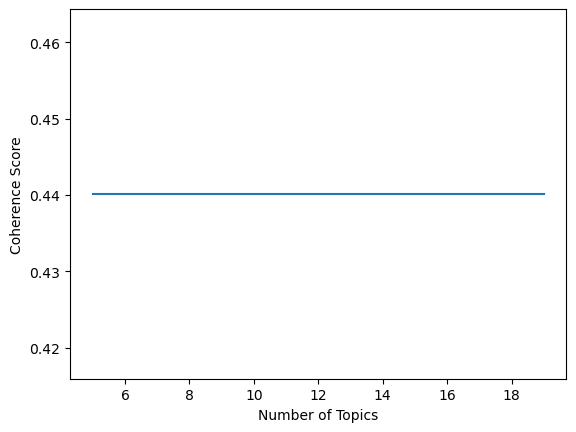

In [33]:
# Loading scores (RUN THIS TO LOAD DATA):
import pickle
with open("cv_scores.pkl", "rb") as f:
    cv_list = pickle.load(f)

x_ax = range(5,20)
y_ax = cv_list
plt.figure()
plt.plot(x_ax, y_ax)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score')


In [34]:
k=5
lda_model = gensim.models.LdaModel(corpus = bow_corpus, id2word=dictionary, 
                                  random_state = 14, iterations=1000,
                                  num_topics=k, passes=20)

In [35]:
def print_topics_gensim(topic_model, total_topics=1,weight_threshold=0.0001,display_weights=False,num_terms=None):
    for index in range(total_topics):
        topic = topic_model.show_topic(index)
        topic = [(word, round(wt,2)) for word, wt in topic if abs(wt) >= weight_threshold]
        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms] if num_terms else topic)
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms] if num_terms else tw)
        print()

In [36]:
print_topics_gensim(topic_model=lda_model,total_topics=k,num_terms=15,display_weights=False)

Topic #1 without weights
['trump', 'biden', 'capitol', 'stimulus', 'dy', 'senate', 'biden’s', 'new', 'republican', 'trump’s']

Topic #2 without weights
['biden’s', 'capitol', 'dy', 'republican', 'stimulus', 'new', 'biden', 'trump', 'senate', 'trump’s']

Topic #3 without weights
['stimulus', 'dy', 'new', 'biden', 'republican', 'senate', 'capitol', 'trump', 'biden’s', 'trump’s']

Topic #4 without weights
['biden', 'stimulus', 'senate', 'new', 'dy', 'republican', 'biden’s', 'trump’s', 'trump', 'capitol']

Topic #5 without weights
['trump’s', 'trump', 'republican', 'capitol', 'senate', 'new', 'stimulus', 'biden', 'dy', 'biden’s']



In [41]:
from wordcloud import WordCloud
for t in range(10):
    plt.imshow(WordCloud().fit(lda_model.show_topic(t)))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

AttributeError: 'WordCloud' object has no attribute 'fit'

<AxesSubplot:title={'center':'Covid & Economic Policy Uncertainity Indices (Feb-Mar)'}, xlabel='date'>

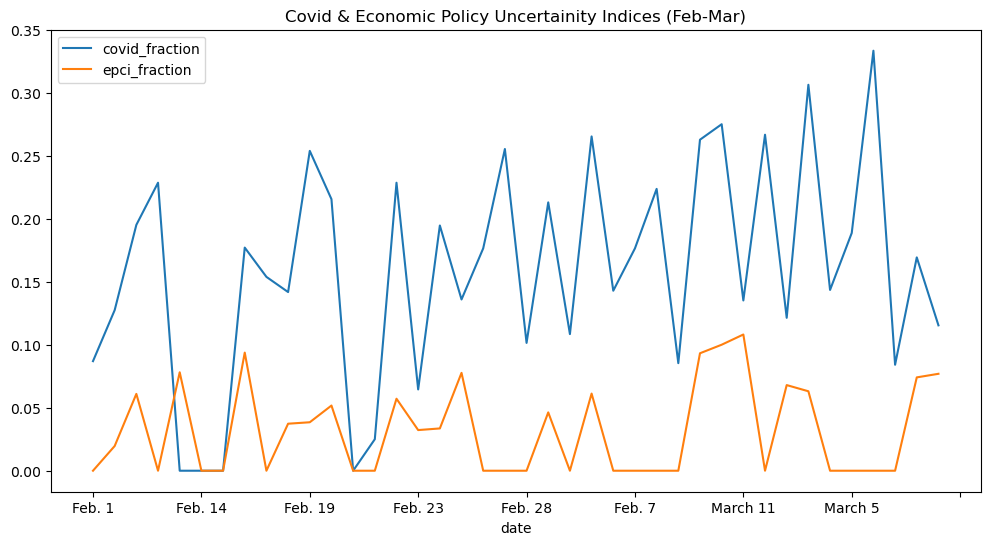

In [12]:
#A5 & 6
nyt['covid_related'] = nyt['Headlines'].apply(lambda x: any(word in x.lower() for word in vocab))
epci = ['econom', 'congress', 'deficit', 'legislation', 'white house', 'uncertain', 'regulat', 'the fed']
nyt['epci_related'] = nyt['Headlines'].apply(lambda x: any(word in x.lower() for word in epci))

# Group the headlines by date and calculate the fraction of Covid-related articles
df_daily = nyt.groupby('date').agg(total=('Headlines', 'count'), covid=('covid_related', 'sum'), epci=('epci_related', 'sum'))
df_daily['covid_fraction'] = df_daily['covid'] / df_daily['total']
df_daily['epci_fraction'] = df_daily['epci'] / df_daily['total']

df_daily[['covid_fraction', 'epci_fraction']].plot(figsize=(12, 6), title="Covid & Economic Policy Uncertainity Indices (Feb-Mar)", 
                                                   legend=True)


**A7**
It is a Coarse Economic Policy Index as it uses a simple identification algorithm to identify articles that are related to Economic Policy Uncertainity Index. The condition for an article to be flagged is elementary and may not identify all the articles properly. Therefore, it has a weak condition to classify articles. Second, it relies on simply one news outlet, New York Times, which does not provide a proper estimate of all publications. 

In [13]:
#A8
sp = pd.read_csv('SP500.csv')
sp['Adj Close**'] = sp['Adj Close**'].str.replace(",", "")
sp['Adj Close**'] = sp['Adj Close**'].astype(float)

In [14]:
sp_1 = sp.iloc[::-1]
sp_1['return'] = sp_1['Adj Close**'].pct_change()

C:\Users\Vivaan\AppData\Local\Temp\ipykernel_41200\3457368012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp_1['return'] = sp_1['Adj Close**'].pct_change()


In [15]:
sp = sp_1.iloc[::-1]
sp.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume,return
0,12-Mar-21,"3,924.52","3,944.99","3,915.21","3,943.34",3943.34,"4,469,240,000",0.001015
1,11-Mar-21,"3,915.54","3,960.27","3,915.54","3,939.34",3939.34,"5,300,010,000",0.010395
2,10-Mar-21,"3,891.99","3,917.35","3,885.73","3,898.81",3898.81,"5,827,250,000",0.006030
3,9-Mar-21,"3,851.93","3,903.76","3,851.93","3,875.44",3875.44,"5,496,340,000",0.014155
4,8-Mar-21,"3,844.39","3,881.06","3,819.25","3,821.35",3821.35,"5,852,240,000",-0.005359


In [16]:
sp[['d1', 'd2', 'd3']] = sp['Date'].str.split('-', expand=True)

C:\Users\Vivaan\AppData\Local\Temp\ipykernel_41200\1870243884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp[['d1', 'd2', 'd3']] = sp['Date'].str.split('-', expand=True)
C:\Users\Vivaan\AppData\Local\Temp\ipykernel_41200\1870243884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp[['d1', 'd2', 'd3']] = sp['Date'].str.split('-', expand=True)
C:\Users\Vivaan\AppData\Local\Temp\ipykernel_41200\1870243884.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFra

In [17]:
i=0
for i in range(len(sp)):
    if sp['d2'][i] == 'Mar':
        sp['d2'][i] = 'March'
    elif sp['d2'][i] == 'Feb':
        sp['d2'][i] = 'Feb.'
    else:
        sp = sp.drop([i])      
    i=i+1

C:\Users\Vivaan\AppData\Local\Temp\ipykernel_41200\3178092080.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp['d2'][i] = 'March'
C:\Users\Vivaan\AppData\Local\Temp\ipykernel_41200\3178092080.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp['d2'][i] = 'Feb.'


In [18]:
ret = sp.drop(['Date', 'Open', 'High', 'Low', 'Close*', 'Volume', 'd3'], axis=1)

In [19]:
ret = ret.drop('Adj Close**', axis=1)

In [20]:
index = df_daily.drop(['total', 'covid', 'epci'], axis=1)
index.reset_index(inplace=True)

In [21]:
index[['d2', 'd1']] = index['date'].str.split(' ', expand=True)

In [22]:
merge = pd.merge(ret, index, on=['d2', 'd1'])

In [23]:
merge['pos'] = merge['return'] > 0

<AxesSubplot:title={'center':'Stock Market Return & Indicies'}>

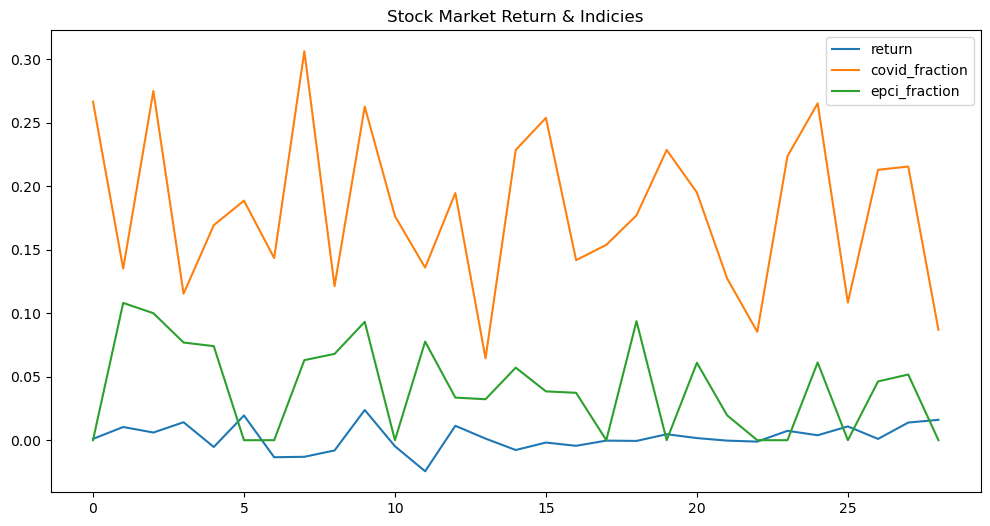

In [24]:
#A9
merge[['return', 'covid_fraction', 'epci_fraction']].plot(figsize=(12, 6), title="Stock Market Return & Indicies", 
                                                   legend=True)

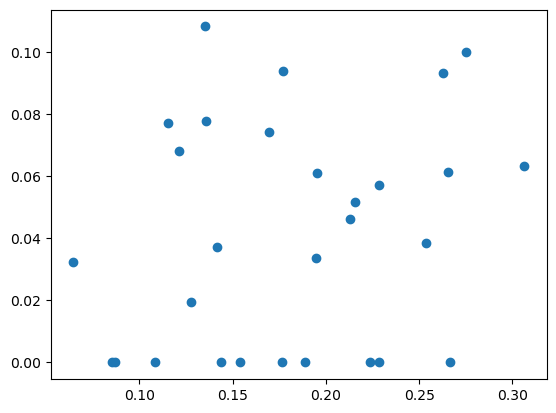

In [42]:
plt.scatter(data=merge, x='covid_fraction', y='epci_fraction')

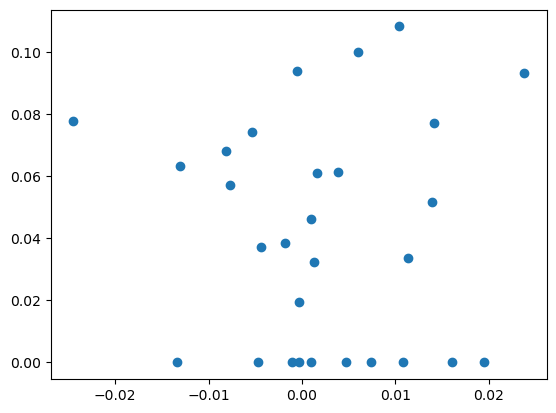

In [43]:
plt.scatter(data=merge, x='return', y='epci_fraction')

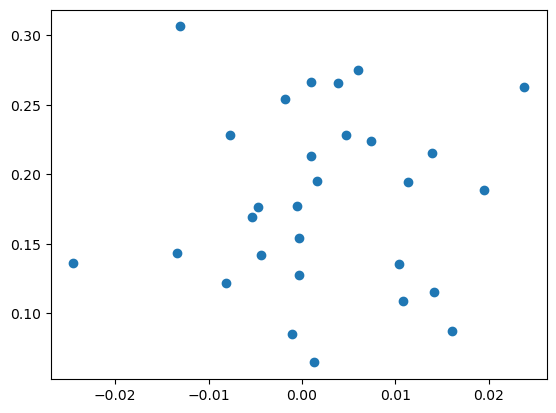

In [44]:
plt.scatter(data=merge, x='return', y='covid_fraction')

In [28]:
#A10a)
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Vivaan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

<AxesSubplot:title={'center':'Daily Sentiment Index (Covid-related headlines)'}, xlabel='date'>

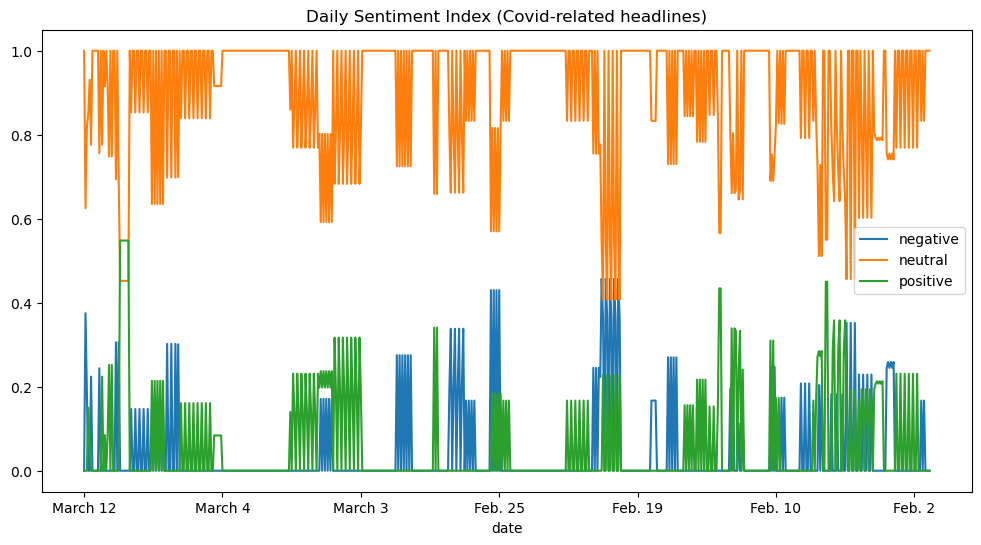

In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

sentiment_scores = []
for i, row in nyt[nyt['covid_related']].iterrows():
    sentiment = analyzer.polarity_scores(row['Headlines'])
    sentiment_scores.append((row['date'], sentiment['neg'], sentiment['neu'], sentiment['pos']))

# Create a new dataframe with the daily sentiment scores
df_sentiment = pd.DataFrame(sentiment_scores, columns=['date', 'negative', 'neutral', 'positive']).set_index('date')

# Plot the daily sentiment index
df_sentiment.plot(figsize=(12, 6), title='Daily Sentiment Index (Covid-related headlines)')


In [30]:
#A10(b)
aggregate_sentiment = df_sentiment.mean()
print('Aggregate Sentiment (Covid-related headlines):\n', aggregate_sentiment)

Aggregate Sentiment (Covid-related headlines):
 negative    0.040941
neutral     0.902309
positive    0.056758
dtype: float64


- The indices used are elementary and classify depending on whether or not a word from defined vocabulatry is mentioned or not. 
- There is a postive, although weak relationships among the indices and stock market return. 